In this notebook, we will build a recomendation system for academic papers.

Below, we download the data we'll be using from GitHub. `vocab2.txt` contains the words in the tiles of the academic papers, and `cb.txt` contains the titles of the papers.

In [54]:
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/data/vocab2.txt
!wget https://github.com/mlittmancs/great_courses_ml/raw/master/data/cb.txt

--2023-09-18 00:22:37--  https://github.com/mlittmancs/great_courses_ml/raw/master/data/vocab2.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/data/vocab2.txt [following]
--2023-09-18 00:22:37--  https://raw.githubusercontent.com/mlittmancs/great_courses_ml/master/data/vocab2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134845 (132K) [text/plain]
Saving to: ‘vocab2.txt.3’

vocab2.txt.3        100%[===================>] 131.68K  --.-KB/s    in 0.07s   

2023-09-18 00:22:37 (1.84 MB/s) - ‘vocab2.txt.3’ saved [134845/134845]

--2023-09-18 00:22:38--  

Here we write a few functions that will help us in processing the data:

- `readvocab` creates a `vocab_dict` with a count of the number of times a word occurs in our paper titles
- `tokenize` turns each set of words in a title, `string`, into a count of the number of times each word in the title occurs
- `getdat`, which takes the titles and returns a list of titles with their word counts, `dat`, and a list of labels indicating if the user found the title interesting, `labs`

We will use our function to process our data to get our vectorized titles, `dat`, and their labels `labs`

In [55]:
# read in the vocabulary file
def readvocab():
   # keep track of the number of words
    lexiconsize = 0
   # initialize an empty dictionary
    vocab_dict = {}
   # create a catch-all feature (vector component) for all unknown words
    vocab_dict["@unk"] = lexiconsize
    lexiconsize += 1
   # read in the vocabulary file
    with open("vocab2.txt", "r") as f:
        data = f.readlines()
   # Process the file a line at a time.
    for line in data:
        # The count is the first 3 characters
        count = int(line[0:4])
        # The word is the rest of the string
        token = line[5:-1]
       # Create a feature if it’s appeared at least twice
        if count > 1:
            vocab_dict[token] = lexiconsize
            lexiconsize += 1
    # squirrel away the total size for later reference
    vocab_dict["@size"] = lexiconsize
    return(vocab_dict)

vocab_dict = readvocab()

# Turn string str into a vector.
def tokenize(string, vocab_dict):
  # initially the vector is all zeros
  vec = [0 for i in range(vocab_dict["@size"])]
  # for each word
  for t in string.split(" "):
   # if the word has a feature, add one to the corresponding feature
    if t in vocab_dict: vec[vocab_dict[t]] += 1
   # otherwise, count it as an unk
    else: vec[vocab_dict["@unk"]] += 1
  return(vec)

# read in labeled examples and turn the strings into vectors
def getdat(vocab_dict):
    with open("cb.txt", "r") as f:
        data = f.readlines()
    dat = []
    labs = []
    for line in data:
        labs = labs + [int(line[0])]
        dat = dat + [tokenize(line[2:], vocab_dict)]
    return(dat, labs)

(dat, labs) = getdat(vocab_dict)

We define two additional helper functions to make our recommendations:

- `playgame` makes `rounds` recommendations using `chooser` and is given a `score`.  For `alpha` days the selections are random.

- `argmax` returns the index from `indices` associated wiht the item in the `vals` list with the highest value

In [56]:
import random
from sklearn.naive_bayes import MultinomialNB

def playgame(chooser, rounds, alpha):
  curitem = 0
  score = 0
  trainset = []
  trainlabs = []
  b = 5
  clf = MultinomialNB()

  while curitem < rounds:
    chosenitem = chooser(curitem, b, trainset, trainlabs, alpha, clf)
    score = score + labs[chosenitem]
    trainset = trainset + [dat[chosenitem]]
    trainlabs = trainlabs + [labs[chosenitem]]
    curitem += b
  return(score)

def argmax(indices, vals):
 best = max(vals)
 for i in range(len(indices)):
   if vals[i] == best:
     return(indices[i])

This function is our choosing function, `probachooser` and chooses between `b` options. `currentitem` is the initial item to consider.  `trainset` represents the results of previous selections.


If we have not yet made `alpha` selections, the selection is random.

If we have made `alpha` selections in the past, we fit our `clf` Naive Bayes model using the traing data of academic papers by title, `trainset`, and training labels for if the academic papers were interesting, `trainlabs`.  After we fit our `clf` model, we use it to select the item most likely to be labeled as interesting.

In [57]:
def probachooser(curitem, b, trainset, trainlabs, alpha, clf):
  if len(trainset) == alpha:
    clf = clf.fit(trainset, trainlabs)
#comment?
  if len(trainset) < alpha:
    chosenitem = random.randint(curitem,curitem+b-1)
  else:
    yhat = clf.predict_proba(dat[curitem:(curitem+b)])
    chosenitem = argmax(range(curitem,curitem+b), [p for (c,p) in yhat])
  return(chosenitem)

We will see how the number of rounds with random choices, `alpha` affects the final score.  We will run our `playgame` function with `alpha` values ranging from 10 to 200.  We will plot our scores below.

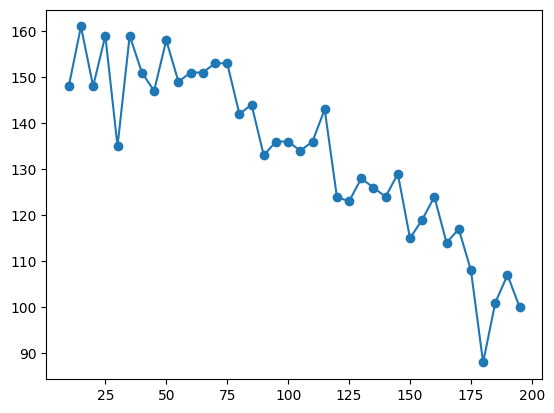

In [58]:
alphas = range(10,200,5)
ress = []
for alpha in alphas:
  res = playgame(probachooser, 1000, alpha)
  ress += [res]

import matplotlib.pyplot as plt

plt.scatter(alphas, ress)
plt.plot(alphas, ress)
plt.show()


We rewrite our `probachooser` function so that `alpha` is now used as a smoothing parameter for our Naive Bayes model, ranging between 0 and 1.  We train our Naive Bayes classifier on every data element using our smoothing parameter in our Naive Bayes model, `alpha`. The `chosenitem` returned is just the one our classifier thinks is most likely to be interesting.

We also will rewrite our `playgame` function to accomodate the changes we made in `probachooser`.

Given these changes, we will plot how our score changes as we vary `alpha` from 0.00005 to 1. Note: Can take 15-20 minutes to run!

In [59]:
def probachooser(curitem, b, trainset, trainlabs, alpha):
  if len(trainset) == 0:
    chosenitem = random.randint(curitem,curitem+b-1)
  else:
    clf = MultinomialNB(alpha=alpha)
    clf = clf.fit(trainset, trainlabs)
    yhat = clf.predict_proba(dat[curitem:(curitem+b)])
    if len(yhat[0]) > 1:
      chosenitem = argmax(range(curitem,curitem+b), [p for (c,p) in yhat])
    else:
      chosenitem = argmax(range(curitem,curitem+b), [p for p in yhat])
  return(chosenitem)

def playgame(chooser, rounds, alpha):
  curitem = 0
  score = 0
  trainset = []
  trainlabs = []
  b = 5

  while curitem < rounds:
    chosenitem = chooser(curitem, b, trainset, trainlabs, alpha)
    score = score + labs[chosenitem]
    trainset = trainset + [dat[chosenitem]]
    trainlabs = trainlabs + [labs[chosenitem]]
    curitem += b
  return(score)

rep = 10
alphas = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
ress = []
mins = []
maxs = []
for alpha in alphas:
  print("Processing " + str(alpha))
  total = 0
  res = []
  for i in range(rep):
    res += [playgame(probachooser, 1000, alpha)]
  ress += [sum(res)/rep]
  mins += [min(res)]
  maxs += [max(res)]

Processing 5e-05
Processing 0.0001
Processing 0.0002
Processing 0.0005
Processing 0.001
Processing 0.002
Processing 0.005
Processing 0.01
Processing 0.02
Processing 0.05
Processing 0.1
Processing 0.2
Processing 0.5
Processing 1.0


We plot the results of varying our smoothing parameter `alpha` below.

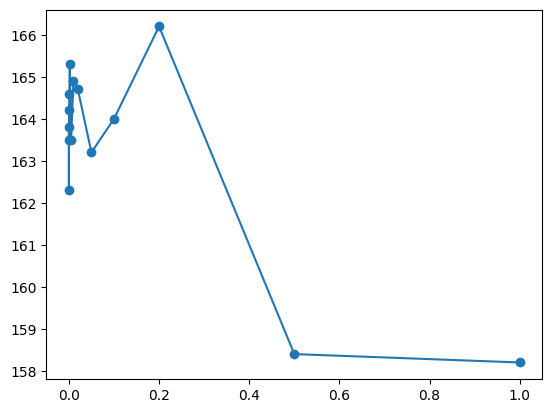

In [60]:
import matplotlib.pyplot as plt

plt.scatter(alphas, ress)
plt.plot(alphas, ress)
# plt.fill_between(alphas, mins, maxs, alpha=0.6)
plt.show()